## Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# from keras.optimizers import RMSprop
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import torch
import torchvision
import torch.nn as nn

sns.set(style='white', context='notebook', palette='deep')

In [3]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Functions

In [6]:
def get_imlist(path_real, path_fake):
  """
  path: dataset root path

  Returns:
  A dictionary with three keys "easy", "mid", "hard", with value being the correspongding
  image name list.
  """
  ret = {}
  ret["easy"] = sorted([os.path.join(path_fake, f) for f in os.listdir(path_fake) if f.startswith('easy')])
  ret["mid"] = sorted([os.path.join(path_fake, f) for f in os.listdir(path_fake) if f.startswith('mid')])
  ret["hard"] = sorted([os.path.join(path_fake, f) for f in os.listdir(path_fake) if f.startswith('hard')])
  ret["real"] = sorted([os.path.join(path_real, f) for f in os.listdir(path_real) if f.endswith('jpg')])
  total_list = ret["easy"] + ret["mid"] + ret["hard"] + ret["real"]
  return ret, total_list

In [7]:
def ELA(path, quality=95):
  prefix = '/content/drive/MyDrive/EECS504/project/archive/real_and_fake_face/training_fake/'
  # prefix = '/content/drive/MyDrive/real_and_fake_face/training_fake/'
  filename = path.split('/')[-1]
  resaved_filename = os.path.join(prefix, 'resave', filename.split('.')[0] + '_resaved.jpg')
  ELA_filename = os.path.join(prefix, 'ela', filename.split('.')[0] + '_ela.png')
  img = Image.open(path).convert('RGB')
  img.save(resaved_filename, 'JPEG', quality=quality)
  resaved_img = Image.open(resaved_filename) 
  ela_img = ImageChops.difference(img, resaved_img)
  # ela_img.save(ELA_filename, quality=quality)

  extrema = ela_img.getextrema()
  max_diff = max([ex[1] for ex in extrema])
  if max_diff == 0:
      max_diff = 1
  scale = 255.0 / max_diff
  
  ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
  
  return ela_img

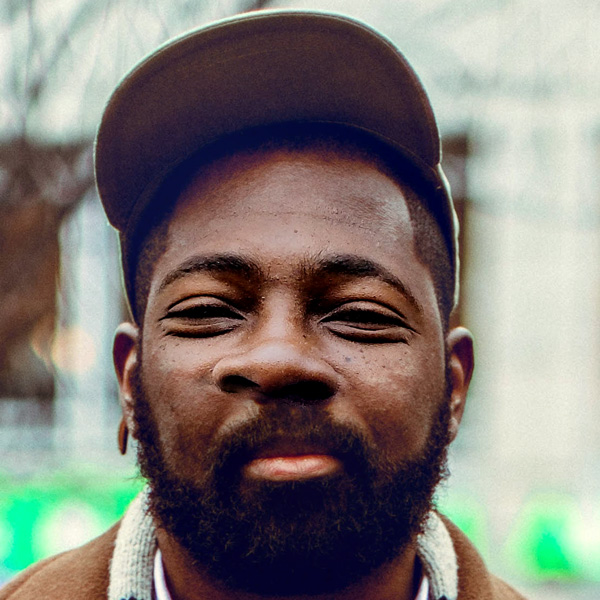

In [8]:
prefix = '/content/drive/MyDrive/EECS504/project/archive/real_and_fake_face/training_fake/'
# prefix = '/content/drive/MyDrive/real_and_fake_face/training_fake/'
filename = 'easy_1_1110.jpg'
sample_img = Image.open(os.path.join(prefix, filename))
sample_img

/content/drive/MyDrive/EECS504/project/archive/real_and_fake_face/training_fake/easy_1_1110.jpg


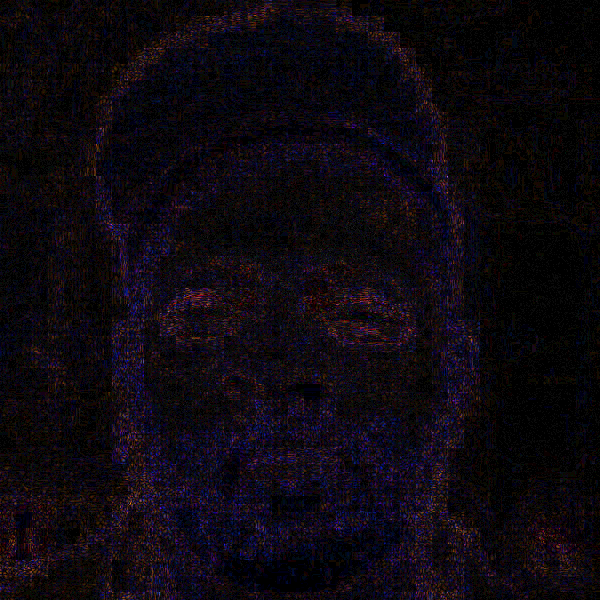

In [9]:
print(os.path.join(prefix, filename))
ELA(os.path.join(prefix, filename))

## Dataset definition

In [10]:
class FacesDataset(torch.utils.data.Dataset):
  def __init__(self, root):
    self.root = roots
    # self.transforms = transforms
    self.imgs_dict, self.imgs = get_imlist(root + "training_real", root + "training_fake")
    # self.imgs = self.imgs[:500]

  def __getitem__(self, idx):
    # img = Image.open(self.imgs[idx])
    path = self.imgs[idx]
    img = ELA(path)
    filename = self.imgs[idx].split('/')[-1]
    # print(filename)
    idx = filename.split('_')[1]
    target = {}
    if not filename.startswith("real"):
      info_str = filename.split('_')[2]
      # print("info str： ", info_str)
      target["manipulated"] = torch.as_tensor(1, dtype=torch.float32)
      target["left_eye"] = torch.as_tensor(int(float(info_str[0])), dtype=torch.float32)
      target["right_eye"] = torch.as_tensor(int(float(info_str[1])), dtype=torch.float32)
      target["nose"] = torch.as_tensor(int(float(info_str[2])), dtype=torch.float32)
      target["mouth"] = torch.as_tensor(int(float(info_str[3])), dtype=torch.float32)  
    else:
      target["manipulated"] = torch.as_tensor(0, dtype=torch.float32)
      target["left_eye"] = torch.as_tensor(0, dtype=torch.float32)
      target["right_eye"] = torch.as_tensor(0, dtype=torch.float32)
      target["nose"] = torch.as_tensor(0, dtype=torch.float32)
      target["mouth"] = torch.as_tensor(0, dtype=torch.float32)

    target["label"] = torch.tensor([target["manipulated"], target["left_eye"], 
                                    target["right_eye"],
                                    target["nose"], target["mouth"]])
    # if self.transforms is not None:
    #   img, target = self.transforms(img, target)
    img = torchvision.transforms.functional.to_tensor(img)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [38]:
DATASET_PATH = "/content/drive/MyDrive/EECS504/project/archive/real_and_fake_face/"
# DATASET_PATH = '/content/drive/MyDrive/real_and_fake_face/'
dataset = FacesDataset(DATASET_PATH)
dataset_test = FacesDataset(DATASET_PATH)
# dataset[0]
print('len', len(dataset))
dataset[0][0].shape

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:1000]) # 40
dataset_test = torch.utils.data.Subset(dataset_test, indices[1000:]) # 20

print(len(dataset), len(dataset_test))

len 2041
1000 1041


## Model Definition

In [39]:
class ConvNet(nn.Module):
  def __init__(self, in_channel=3, channel_1=256, num_output=5):
    super().__init__()
    # (N, in_channel, 600, 600) -> (N, 32, 300, 300) -> (N, 32, 150, 150) -> 
    # (N, 32, 75, 75) -> (N*32*150*150)
    N, W, H = 2, 600, 600
    self.conv_net = nn.Sequential(
        nn.Conv2d(in_channel, 32, kernel_size=5, padding=2, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 32, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.25),
        nn.Flatten(),
        nn.Linear(32*75*75, channel_1),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(channel_1, num_output),
    )
  def forward(self, x):
    scores = self.conv_net(x)
    return scores

In [13]:
def extract_img_and_target(imgs_temp, targets_temp):
  imgs = torch.cat([sample.reshape(1, *sample.shape) for sample in imgs_temp], dim=0)
  targets = []
  for item in targets_temp:
    targets.append(item["label"])
  targets = torch.cat([t.reshape(1, -1) for t in targets], dim=0)
  return imgs, targets

def collate_fn(batch):
  imgs_temp, targets_temp = tuple(zip(*batch))
  imgs, targets = extract_img_and_target(imgs_temp, targets_temp)
  # return torch.cat([sample.reshape(1, *sample.shape) for sample in ret[0]], dim=0)
  return (imgs, targets)

In [40]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=collate_fn)
len(data_loader)

250

In [41]:
it = iter(data_loader)
imgs_temp, targets_temp = it.next()
print(imgs_temp.shape, targets_temp.shape)

torch.Size([4, 3, 600, 600]) torch.Size([4, 5])


## Training Loop

In [49]:
model = ConvNet(3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device=device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=5e-5, betas=(0.95, 0.9), eps=1e-4)
print(device)

cuda


In [43]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, loss_history, print_freq=10):
  model.train()
  for i, obj in enumerate(data_loader):
    images, targets = obj
    images = images.to(device)
    targets = targets.to(device)
    scores = model(images)
    loss = nn.functional.binary_cross_entropy_with_logits(scores, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss)

    if i % print_freq == 0:
      print(f'Epoch: [{epoch}] [ {i} / {len(data_loader)} ], loss: [{loss.item()}]')
    elif epoch == len(data_loader)-1:
      print(f'Epoch: [{epoch}] [ {len(data_loader)} / {len(data_loader)} ], loss: [{loss.item()}]')

In [44]:
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, loss_history)

Epoch: [0] [ 0 / 250 ], loss: [0.6901076436042786]
Epoch: [0] [ 10 / 250 ], loss: [0.784045934677124]
Epoch: [0] [ 20 / 250 ], loss: [0.7758809924125671]
Epoch: [0] [ 30 / 250 ], loss: [0.600631058216095]
Epoch: [0] [ 40 / 250 ], loss: [0.7726321220397949]
Epoch: [0] [ 50 / 250 ], loss: [0.5990018844604492]
Epoch: [0] [ 60 / 250 ], loss: [0.7303019762039185]
Epoch: [0] [ 70 / 250 ], loss: [0.7485660910606384]
Epoch: [0] [ 80 / 250 ], loss: [0.4285034239292145]
Epoch: [0] [ 90 / 250 ], loss: [0.7882864475250244]
Epoch: [0] [ 100 / 250 ], loss: [0.9131284952163696]
Epoch: [0] [ 110 / 250 ], loss: [0.6600693464279175]
Epoch: [0] [ 120 / 250 ], loss: [0.7520005106925964]
Epoch: [0] [ 130 / 250 ], loss: [0.501136839389801]
Epoch: [0] [ 140 / 250 ], loss: [0.8230493664741516]
Epoch: [0] [ 150 / 250 ], loss: [0.6123831868171692]
Epoch: [0] [ 160 / 250 ], loss: [0.668609619140625]
Epoch: [0] [ 170 / 250 ], loss: [0.5967322587966919]
Epoch: [0] [ 180 / 250 ], loss: [0.8772598505020142]
Epoch: [

KeyboardInterrupt: ignored

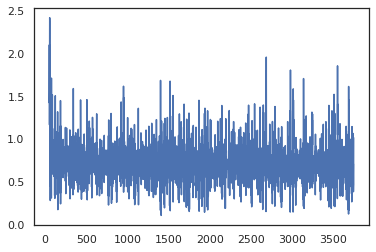

In [34]:
plt.plot(np.arange(len(loss_history))[50:], loss_history[50:])

## Save, load and evaluate the model

In [ ]:
save_addr = '/content/drive/MyDrive/EECS504/project/archive/real_and_fake_face/training_fake/model.pt'
torch.save(model.state_dict(), save_addr)
print(f'Saved to: {save_addr}')

In [45]:
save_addr = '/content/drive/MyDrive/EECS504/project/archive/real_and_fake_face/training_fake/model.pt'
model.load_state_dict(torch.load(save_addr))
model.eval()

ConvNet(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=180000, out_features=256, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=256, out_features=5, bias=True)
  )
)

Test cases in the training set:

In [41]:
test_img, target_test = dataset[150]
print(test_img.shape)
prediction = model(test_img.to(device=device).unsqueeze(dim=0))
print('prediction', torch.sigmoid(prediction))
print(target_test)

torch.Size([3, 600, 600])
prediction tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 4.7644e-11, 1.5741e-08]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
{'manipulated': tensor(1.), 'left_eye': tensor(1.), 'right_eye': tensor(1.), 'nose': tensor(0.), 'mouth': tensor(0.), 'label': tensor([1., 1., 1., 0., 0.])}


Test cases in the test set:

In [48]:
# test_dataset = FacesDataset_test(DATASET_PATH)
test_img, target_test = dataset_test[50]
print(test_img.shape)
prediction = model(test_img.to(device=device).unsqueeze(dim=0))
print('prediction', torch.sigmoid(prediction))
print(target_test)

torch.Size([3, 600, 600])
prediction tensor([[1.0000e+00, 1.7260e-08, 5.6634e-06, 1.0000e+00, 1.0000e+00]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
{'manipulated': tensor(1.), 'left_eye': tensor(0.), 'right_eye': tensor(0.), 'nose': tensor(1.), 'mouth': tensor(1.), 'label': tensor([1., 0., 0., 1., 1.])}
